# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

## 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print (brain_name)
print (brain)

TennisBrain
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
env_action_size = brain.vector_action_space_size
print('Size of each action:', env_action_size)

# examine the state space 
states = env_info.vector_observations
env_state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], env_state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]


## 3. Take Random Actions in the Environment (Optional)

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, env_action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

## 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 4.1 Setup

In [5]:
import random
import torch
import os
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt
import Dict_Hyperparams as P

from MADDPG_Agents import MADDPG
from datetime import datetime

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

### 4.2 Training Runner

In [6]:
from MADDPG_Agents import MADDPG

def maddpg_train(n_episodes=10000, max_t=1000, print_every=100, random_seed=10, nameModel = ""):  
    
    # Seeding
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Instantiate the MADDPG agents
    maddpg = MADDPG(env_state_size, env_action_size, num_agents, random_seed)

    # Monitor the score    
    scores_episode_deque = deque(maxlen=print_every)
    all_scores = []
    all_avg_score = []
    
    
    # Training Loop
    for i_episode in range(n_episodes+1):  
             
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)

        for steps in range(max_t):

            actions = maddpg.act(states)                    # retrieve actions to performe for each agents
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # Save experience in replay memory, and use random sample from buffer to learn
            maddpg.step(states, actions, rewards, next_states, dones)  

            scores += env_info.rewards                             # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                break
        
        # Save scores and compute average score over last n episodes       
        best_score  = np.max(scores)  # Consider the maximum score amongs all Agents
        all_scores.append(best_score)
        
        scores_episode_deque.append(best_score)
        avg_score = np.mean(scores_episode_deque)

        # Display statistics 
        print('\rEpisode {}\tAverage Score: {:.2f}\t Episode score (max over agents): {:.2f}'.format(i_episode, avg_score, best_score), end="")
        if i_episode>0 and i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} '.format(i_episode, avg_score))
            maddpg.save_checkpoints(nameModel)
            all_avg_score.append(avg_score)
        
        # Early stop
        if avg_score >=0.5:
            print()
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score), end="")
            maddpg.save_checkpoints(nameModel)
            return all_scores

    return all_scores

### 4.3 Plot Training Result

In [7]:
def plot_training(scores):
    # Plot the Score evolution during the training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='deepskyblue')
    ax.tick_params(axis='y', colors='deepskyblue')
    plt.plot(np.arange(1, len(scores)+1), scores, color='deepskyblue')
    plt.ylabel('Score', color='deepskyblue')
    plt.xlabel('Episode #', color='deepskyblue')
    plt.show()

### 4.4 Main Code

Episode 100	Average Score: 0.02  Episode score (max over agents): 0.00
Episode 200	Average Score: 0.01  Episode score (max over agents): 0.00
Episode 300	Average Score: 0.00  Episode score (max over agents): 0.00
Episode 400	Average Score: 0.00  Episode score (max over agents): 0.00
Episode 500	Average Score: 0.01  Episode score (max over agents): 0.00
Episode 600	Average Score: 0.02  Episode score (max over agents): 0.00
Episode 700	Average Score: 0.04  Episode score (max over agents): 0.10
Episode 800	Average Score: 0.04  Episode score (max over agents): 0.10
Episode 900	Average Score: 0.09  Episode score (max over agents): 0.10
Episode 1000	Average Score: 0.42  Episode score (max over agents): 0.30
Episode 1033	Average Score: 0.51	 Episode score (max over agents): 1.90
Environment solved in 1033 episodes with an Average Score of 0.51
Elapsed Time: 1:04:35.780128


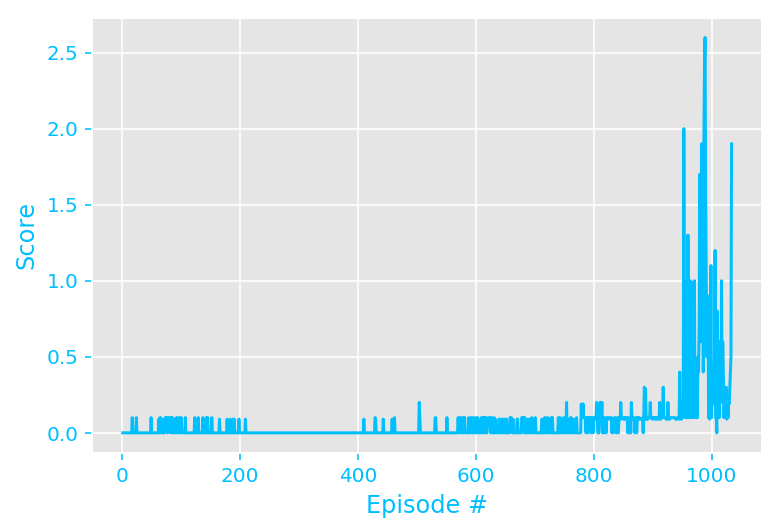

In [8]:
start_time = datetime.now()

scores = maddpg_train(n_episodes=10000, max_t=1000, print_every=100, random_seed=10, 
                      nameModel = "v3")

end_time = datetime.now()
elapsed_time = end_time - start_time
print()
print(f"Elapsed Time: {elapsed_time}")

plot_training(scores)